# Steven VanOmmeren
# Week 12 Coding Assignment 2

STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Deep Convolutional GAN Trained on ~~CelebA~~ MNIST

## Imports

In [38]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [39]:
from helper_data import get_dataloaders_celeba
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [40]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 15
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cuda:0


In [41]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

# Problem 2.
Adapt the DCGAN to work on MNIST image data

In [42]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=custom_transforms,
                               download=True)

print(f"\nOriginal train dataset size: {len(train_dataset)}.")

# NEW: Load the test dataset
test_dataset = datasets.MNIST(root='data',
                               train=False,
                               transform=custom_transforms,
                               download=True)

# NEW: Merge train and test datasets
train_dataset.data = torch.cat((train_dataset.data, test_dataset.data), dim=0)
train_dataset.targets = torch.cat((train_dataset.targets, test_dataset.targets), dim=0)

print(f"Combined dataset size: {len(train_dataset)}.")

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Original train dataset size: 60000.
Combined dataset size: 70000.
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [43]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Note
To adapt the DCGAN from the original notebook to work with MNIST data, I made the following changes:
- Change resolution: the celeb data was 64 x 64 pixels, while MNIST is 28 x 28
- Change color channels: the celeb data had 3 color channels, while MNIST has 1 (black/white)
- Change model architecture: the generator and discriminator need to adapt to the new resolution of images.
    - Old generator: 1x1 -> 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64
    - New generator: 1x1 -> 4x4 -> 7x7 -> 14x14 -> 28x28

Running this new model as-is resulted in garbage output. It took an enormous amount of experimentation before I could get something that didn't output random noise values. I took some inspiration from this GitHub repository (https://github.com/AKASHKADEL/dcgan-mnist/tree/master). The common issue was that the discriminator loss would immediately go to zero, so the generator gradients were flat and could not improve.

- used ReLU in generator instead of LeakyReLU

In [44]:
##########################
### MODEL
##########################

class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=1):
        super().__init__()
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*4, 
                               kernel_size=4, stride=1, padding=0, bias=False), # 4x4
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=3, stride=2, padding=1, bias=False), # 7x7
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, 
                               kernel_size=4, stride=2, padding=1, bias=False), # 14x14
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, 
                               kernel_size=4, stride=2, padding=1, bias=False), # 28x28

            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
           
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1, bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=3, stride=2, padding=1, bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_feat_maps_dis*4, 1,
                      kernel_size=4, stride=1, padding=0),

            nn.Flatten(),
        )

    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [45]:
set_all_seeds(RANDOM_SEED)

model = DCGAN()
model.to(DEVICE)

optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

## Training

In [46]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')

Epoch: 001/015 | Batch 000/547 | Gen/Dis Loss: 0.9304/0.7534
Epoch: 001/015 | Batch 100/547 | Gen/Dis Loss: 6.3213/0.0051
Epoch: 001/015 | Batch 200/547 | Gen/Dis Loss: 2.8658/0.2136
Epoch: 001/015 | Batch 300/547 | Gen/Dis Loss: 2.3541/0.2231
Epoch: 001/015 | Batch 400/547 | Gen/Dis Loss: 1.6857/0.2699
Epoch: 001/015 | Batch 500/547 | Gen/Dis Loss: 1.1723/0.3190
Time elapsed: 0.35 min
Epoch: 002/015 | Batch 000/547 | Gen/Dis Loss: 1.7305/0.2509
Epoch: 002/015 | Batch 100/547 | Gen/Dis Loss: 1.4664/0.3813
Epoch: 002/015 | Batch 200/547 | Gen/Dis Loss: 2.3339/0.1981
Epoch: 002/015 | Batch 300/547 | Gen/Dis Loss: 3.0150/0.2883
Epoch: 002/015 | Batch 400/547 | Gen/Dis Loss: 2.2912/0.1975
Epoch: 002/015 | Batch 500/547 | Gen/Dis Loss: 0.2733/0.6496
Time elapsed: 0.70 min
Epoch: 003/015 | Batch 000/547 | Gen/Dis Loss: 0.4016/0.4810
Epoch: 003/015 | Batch 100/547 | Gen/Dis Loss: 0.7952/0.3289
Epoch: 003/015 | Batch 200/547 | Gen/Dis Loss: 1.4978/0.2516
Epoch: 003/015 | Batch 300/547 | Gen/Di

## Evaluation

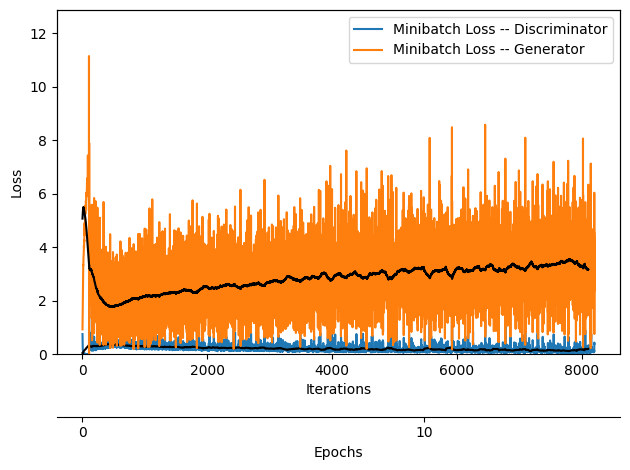

In [47]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

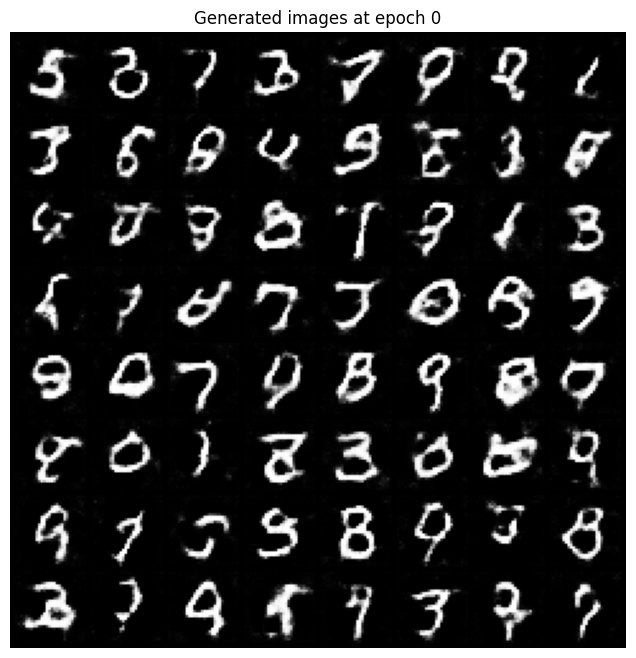

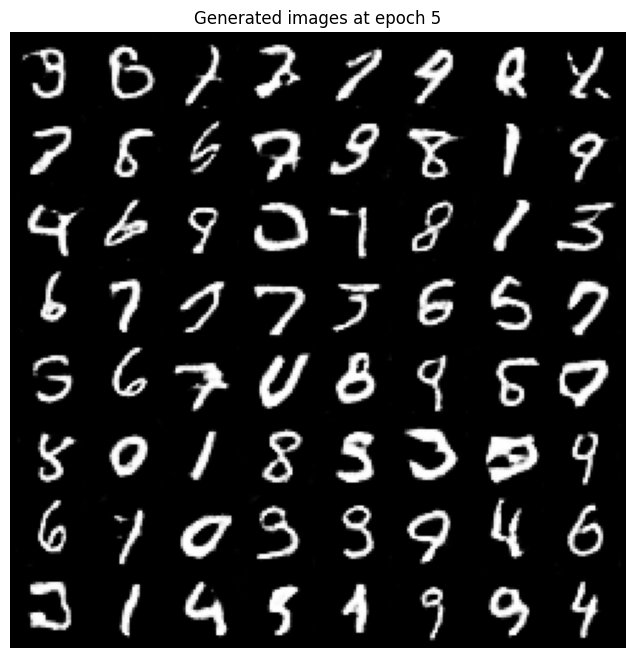

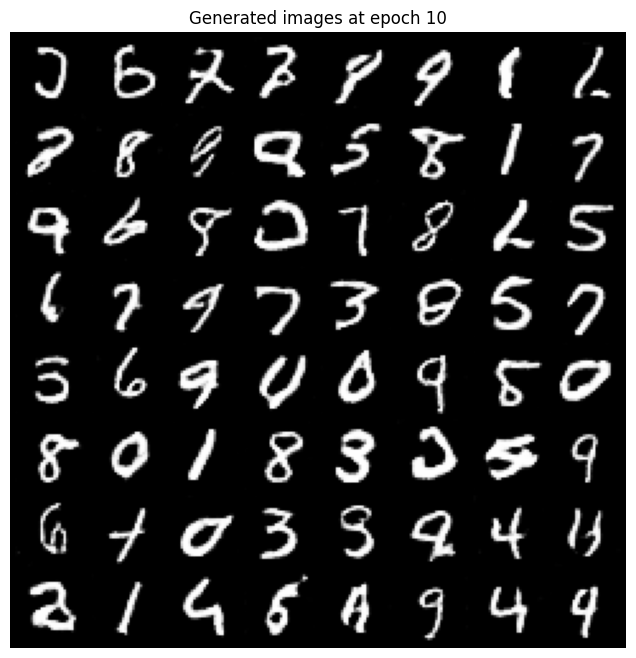

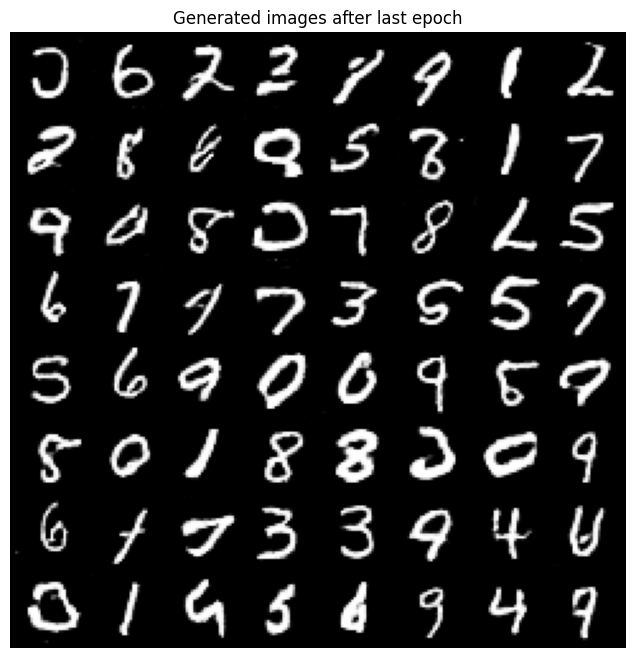

In [48]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

# Problem 3:
Run the GAN and DCGAN and look at the generated image quality. Explore whether increasing the epochs or network complexity in a GAN allows it to match a DCGAN.

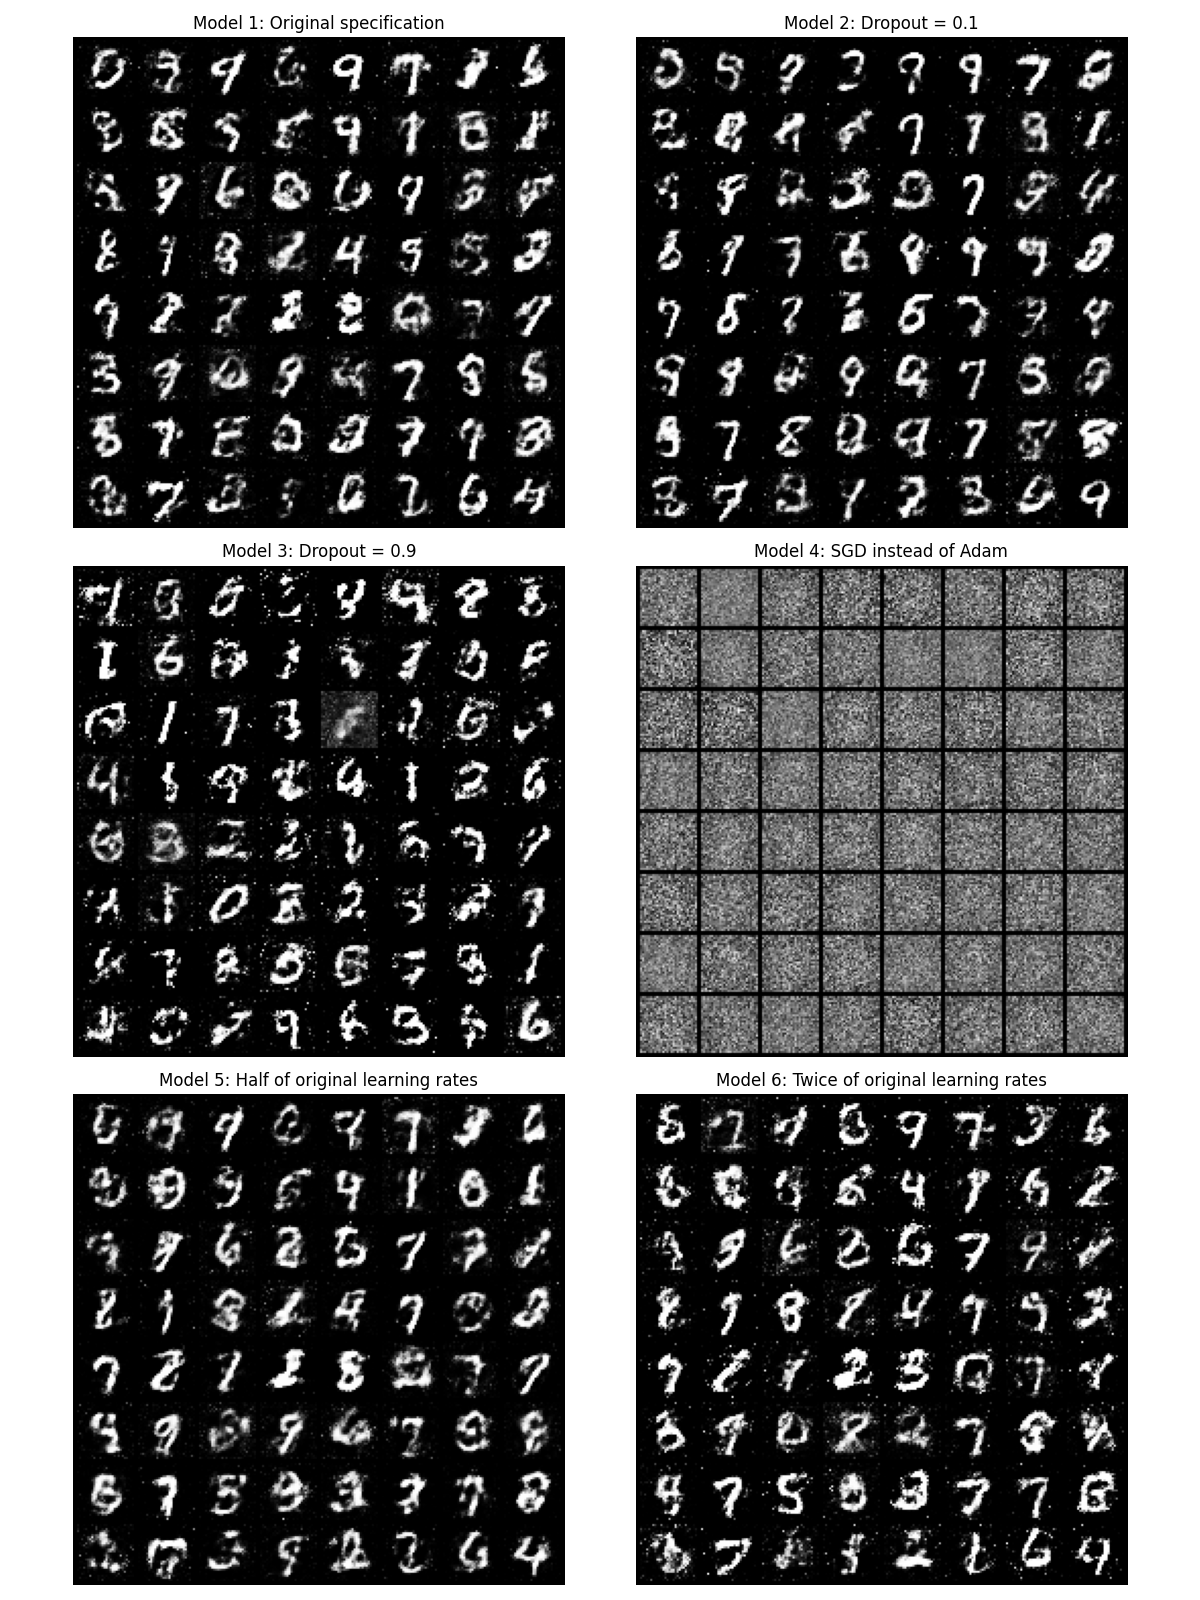

In [49]:
# Display GAN results from Homework 1
from IPython import display
display.Image("model results.png")

Comparing the outputs of the DC-GAN with my previous GANs, it's clear that the DC-GAN is far superior in creating clear outputs that resemble actual digits. So, we will try two new models: 
- running the original GAN for more epochs
- running a GAN with more complexity (two additional linear layers with 128 neurons)

In [50]:
def train_gan(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=NUM_EPOCHS,
        latent_dim=100,
        logging_interval=100,
        model_name=None
    ):
    # Define a model name based on the chosen hyperparameters
    if model_name is None:
        model_name = f'gan_mnist_dr{dropout}_adam{use_Adam}_lrg{learning_rate_gen}_lrd{learning_rate_dis}.pt'

    # Define the models
    class GAN(torch.nn.Module):
        def __init__(self, latent_dim=latent_dim,
                    image_height=28, image_width=28, color_channels=1):
            super().__init__()
            self.image_height = image_height
            self.image_width = image_width
            self.color_channels = color_channels
            self.generator = nn.Sequential(
                nn.Linear(latent_dim, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, image_height*image_width*color_channels),
                nn.Tanh()
            )
            self.discriminator = nn.Sequential(
                nn.Flatten(),
                nn.Linear(image_height*image_width*color_channels, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, 1), # outputs logits
            )
        def generator_forward(self, z):# z has dimension NCHW
            z = torch.flatten(z, start_dim=1)
            img = self.generator(z)
            img = img.view(z.size(0),
                        self.color_channels,
                        self.image_height,
                        self.image_width)
            return img
        def discriminator_forward(self, img):
            logits = model.discriminator(img)
            return logits

    # Setup the model
    set_all_seeds(RANDOM_SEED)
    model = GAN()
    model.to(DEVICE)

    if use_Adam:
        optim_gen = torch.optim.Adam(model.generator.parameters(),
                                    betas=(0.5, 0.999),
                                    lr=learning_rate_gen)

        optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                                    betas=(0.5, 0.999),
                                    lr=learning_rate_dis)
    else:
        optim_gen = torch.optim.SGD(model.generator.parameters(),
                                    lr=learning_rate_gen)

        optim_discr = torch.optim.SGD(model.discriminator.parameters(),
                                    lr=learning_rate_dis)

    log_dict = train_gan_v1(num_epochs=num_epochs, model=model,
                    optimizer_gen=optim_gen,
                    optimizer_discr=optim_discr,
                    latent_dim=latent_dim,
                    device=DEVICE,
                    train_loader=train_loader,
                    logging_interval=logging_interval,
                    save_model=model_name)

    return log_dict

In [51]:
model_1 = train_gan(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=100, # original model had 50 epochs
        latent_dim=100,
        logging_interval=547, # 1 output per epoch
        model_name=None
    )

Epoch: 001/100 | Batch 000/547 | Gen/Dis Loss: 0.7361/0.6865
Time elapsed: 0.23 min
Epoch: 002/100 | Batch 000/547 | Gen/Dis Loss: 1.0675/0.3888
Time elapsed: 0.46 min
Epoch: 003/100 | Batch 000/547 | Gen/Dis Loss: 1.0339/0.4375
Time elapsed: 0.70 min
Epoch: 004/100 | Batch 000/547 | Gen/Dis Loss: 1.1160/0.4867
Time elapsed: 0.92 min
Epoch: 005/100 | Batch 000/547 | Gen/Dis Loss: 1.2855/0.4868
Time elapsed: 1.14 min
Epoch: 006/100 | Batch 000/547 | Gen/Dis Loss: 1.1442/0.4961
Time elapsed: 1.35 min
Epoch: 007/100 | Batch 000/547 | Gen/Dis Loss: 1.1249/0.5165
Time elapsed: 1.56 min
Epoch: 008/100 | Batch 000/547 | Gen/Dis Loss: 1.1047/0.5230
Time elapsed: 1.77 min
Epoch: 009/100 | Batch 000/547 | Gen/Dis Loss: 1.1585/0.5228
Time elapsed: 2.01 min
Epoch: 010/100 | Batch 000/547 | Gen/Dis Loss: 1.3030/0.4727
Time elapsed: 2.24 min
Epoch: 011/100 | Batch 000/547 | Gen/Dis Loss: 1.2548/0.5073
Time elapsed: 2.48 min
Epoch: 012/100 | Batch 000/547 | Gen/Dis Loss: 1.2455/0.5251
Time elapsed: 2

In [63]:
def train_gan_complex(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=NUM_EPOCHS,
        latent_dim=100,
        logging_interval=100,
        model_name=None
    ):
    # Define a model name based on the chosen hyperparameters
    if model_name is None:
        model_name = f'gan_mnist_dr{dropout}_adam{use_Adam}_lrg{learning_rate_gen}_lrd{learning_rate_dis}.pt'

    # Define the models
    class GAN(torch.nn.Module):
        def __init__(self, latent_dim=latent_dim,
                    image_height=28, image_width=28, color_channels=1):
            super().__init__()
            self.image_height = image_height
            self.image_width = image_width
            self.color_channels = color_channels
            self.generator = nn.Sequential(
                nn.Linear(latent_dim, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, image_height*image_width*color_channels),
                nn.Tanh()
            )
            self.discriminator = nn.Sequential(
                nn.Flatten(),
                nn.Linear(image_height*image_width*color_channels, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, 1), # outputs logits
            )
        def generator_forward(self, z):# z has dimension NCHW
            z = torch.flatten(z, start_dim=1)
            img = self.generator(z)
            img = img.view(z.size(0),
                        self.color_channels,
                        self.image_height,
                        self.image_width)
            return img
        def discriminator_forward(self, img):
            logits = model.discriminator(img)
            return logits

    # Setup the model
    set_all_seeds(RANDOM_SEED)
    model = GAN()
    model.to(DEVICE)

    if use_Adam:
        optim_gen = torch.optim.Adam(model.generator.parameters(),
                                    betas=(0.5, 0.999),
                                    lr=learning_rate_gen)

        optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                                    betas=(0.5, 0.999),
                                    lr=learning_rate_dis)
    else:
        optim_gen = torch.optim.SGD(model.generator.parameters(),
                                    lr=learning_rate_gen)

        optim_discr = torch.optim.SGD(model.discriminator.parameters(),
                                    lr=learning_rate_dis)

    log_dict = train_gan_v1(num_epochs=num_epochs, model=model,
                    optimizer_gen=optim_gen,
                    optimizer_discr=optim_discr,
                    latent_dim=latent_dim,
                    device=DEVICE,
                    train_loader=train_loader,
                    logging_interval=logging_interval,
                    save_model=model_name)

    return log_dict

In [64]:
model_2 = train_gan_complex(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=25, # original model had 50 epochs
        latent_dim=100,
        logging_interval=547, # 1 output per epoch
        model_name=None
    )

Epoch: 001/025 | Batch 000/547 | Gen/Dis Loss: 0.6705/0.7078
Time elapsed: 0.24 min
Epoch: 002/025 | Batch 000/547 | Gen/Dis Loss: 3.2531/0.2209
Time elapsed: 0.49 min
Epoch: 003/025 | Batch 000/547 | Gen/Dis Loss: 2.1988/0.2882
Time elapsed: 0.74 min
Epoch: 004/025 | Batch 000/547 | Gen/Dis Loss: 1.7195/0.3927
Time elapsed: 0.98 min
Epoch: 005/025 | Batch 000/547 | Gen/Dis Loss: 1.6724/0.4636
Time elapsed: 1.24 min
Epoch: 006/025 | Batch 000/547 | Gen/Dis Loss: 1.4532/0.4670
Time elapsed: 1.50 min
Epoch: 007/025 | Batch 000/547 | Gen/Dis Loss: 1.5300/0.4618
Time elapsed: 1.75 min
Epoch: 008/025 | Batch 000/547 | Gen/Dis Loss: 1.3219/0.4999
Time elapsed: 2.01 min
Epoch: 009/025 | Batch 000/547 | Gen/Dis Loss: 1.3896/0.4593
Time elapsed: 2.26 min
Epoch: 010/025 | Batch 000/547 | Gen/Dis Loss: 1.4261/0.5122
Time elapsed: 2.52 min
Epoch: 011/025 | Batch 000/547 | Gen/Dis Loss: 1.2209/0.5391
Time elapsed: 2.77 min
Epoch: 012/025 | Batch 000/547 | Gen/Dis Loss: 1.2045/0.4879
Time elapsed: 3

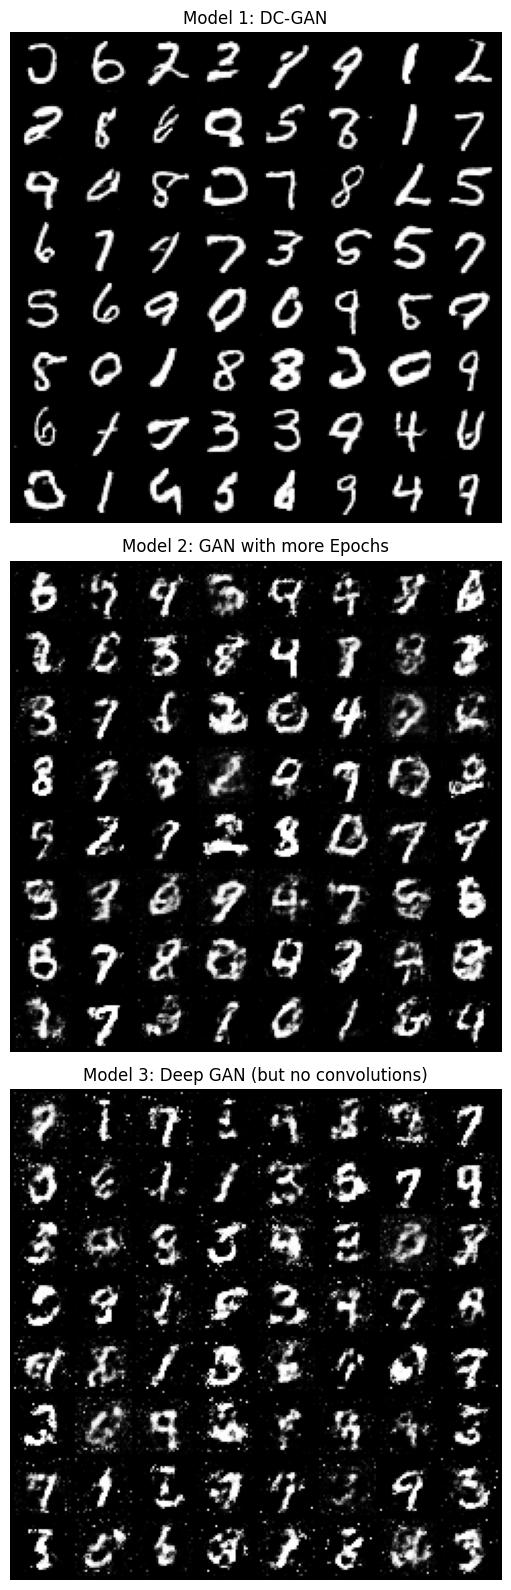

In [65]:
# Now we plot all the results

# Create a figure with 3 rows and 1 columns
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# Model titles
titles = [
    "Model 1: DC-GAN",
    "Model 2: GAN with more Epochs",
    "Model 3: Deep GAN (but no convolutions)"
]

# Models list
models = [log_dict, model_1, model_2]

# Plot each model
for idx, (ax, model, title) in enumerate(zip(axes.flatten(), models, titles)):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(np.transpose(model['images_from_noise_per_epoch'][-1], (1, 2, 0)))

plt.tight_layout()
plt.savefig('model results hw 2.png')
plt.show()

Problem 3 discussion: I tried two non-convolutional models to attempt to beat my DC-GAN. Running the original GAN model for twice as many epochs did not improve performance, while my deep GAN with additional linear layers results in even worse output than the original model, with many of the output digits being completely unrecognizable. In contrast, the DC-GAN images are much more believable and look like they were actually handwritten by a human. I attribute this increased performance to the convolutional filters extracting common patterns throughout the image, whereas the linear (fully-connected) layers can only analyze fixed patterns between pixels. The DC-GAN is clearly superior for working with image data.